In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mutual_info_score

/home/mukesh/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#DATA_PATH = 'https://query.data.world/s/tlgtqdn7n7oeq2wg66kxxtbokmsmn5'
DATA_PATH = 'data/2010 Federal STEM Education Inventory Data Set.xls'

In [4]:
def data_retriever(data_path):
   
    results = pd.read_excel(data_path,header=1)
    
    for i in results.columns:
        if i[:7] == "Unnamed":
            results.rename(columns={i:j+" "+str(k)},inplace=True)
            k=k+1
        else:
            j=i
            k=1
        
    return results

### Stage. 1

In [5]:
df = data_retriever(DATA_PATH)

In [6]:
# Check missing values
df.isnull().sum()/len(df)

Index Number                                       0.003953
Investment Name                                    0.003953
Agency                                             0.003953
Subagency                                          0.063241
A) Brief Description                               0.003953
B) Year Established                                0.047431
C1) Funding FY2008                                 0.086957
C2) Funding FY2009                                 0.035573
C3) Funding FY2010                                 0.000000
D) Mission-specific or General STEM?               0.003953
E) Agency or Mission-Related Workforce Needs?      0.565217
F1) Primary Investment Objective                   0.003953
F2) Secondary Investment Objectives                0.458498
F2) Secondary Investment Objectives 1              0.513834
F2) Secondary Investment Objectives 2              0.679842
F2) Secondary Investment Objectives 3              0.656126
F2) Secondary Investment Objectives 4   

In [7]:
df['C1) Funding FY2008'].fillna(0,inplace=True)
df['C2) Funding FY2009'].fillna(0,inplace=True)

In [8]:
def compute_growth(data):
    growth = []
    
    for i in range(len(data)):
        if df['C1) Funding FY2008'][i] == 0:
            if df['C2) Funding FY2009'][i] == 0:
                growth.append(0)
            elif df['C2) Funding FY2009'][i] < 0:
                growth.append(-100)
            else:
                growth.append(100)
        else:
            g = ((df['C2) Funding FY2009'][i] - df['C1) Funding FY2008'][i])/df['C1) Funding FY2008'][i])*100
            growth.append(g)
    return growth

In [9]:
df['Percent_Growth'] = compute_growth(df)

df['Target'] = (df['Percent_Growth'] >= 0).astype(int)

In [10]:
# Store target variable separately, so we can use it during testing using pytest
test_target = df['Target']

### Stage. 2

### Cleaning the data

1. Drop the features with more than 40% missing values
2. Count unique values in every feature
3. Drop feature which has every value unique or has only one unique value

In [11]:
cols_to_drop = []

cols = list(df.isnull().sum()/len(df) > 0.4)

data_cols = df.columns.tolist()
for i in range(len(data_cols)):
    if cols[i] == True:
        cols_to_drop.append(data_cols[i])

df.drop(columns=cols_to_drop,axis=1,inplace=True)

In [12]:
for feature in df.columns.tolist():
    print(feature +" : " + str(len(df[feature].unique())))

Index Number : 253
Investment Name : 252
Agency : 14
Subagency : 65
A) Brief Description : 253
B) Year Established : 40
C1) Funding FY2008 : 198
C2) Funding FY2009 : 218
C3) Funding FY2010 : 218
D) Mission-specific or General STEM? : 3
F1) Primary Investment Objective : 8
H) Educational Services or Products Produced 7 : 2
H) Educational Services or Products Produced 10 : 2
I1) STEM Learners Targeted? Specify. : 3
J) Focus on Underrepresented Groups in STEM : 3
K) Eligibility Restrictions : 3
L) Minority Serving Institutions : 4
Q) Legislation Required to Shift Focus? : 4
U) Measured Outputs : 3
U) Measured Outputs 1 : 2
Percent_Growth : 183
Target : 2


In [13]:
cols_to_drop = ['Index Number','A) Brief Description',
                'Investment Name','H) Educational Services or Products Produced 7',
                'H) Educational Services or Products Produced 10',
                'U) Measured Outputs 1','Percent_Growth']
df.drop(columns=cols_to_drop,axis=1,inplace=True)

### Plot the Data

Plot graphs of univariate distribution of all non funding variables.

In [14]:
def plot(data):
    funding_vars = ['C1) Funding FY2008', 'C2) Funding FY2009', 'C3) Funding FY2010']
            
    plot_size = len(df['Agency'].unique())/2
   
    for feature in df.columns:
        if feature not in funding_vars:
            plt.figure(num=None, figsize=(plot_size, plot_size), dpi=80, facecolor='w', edgecolor='k')
            sns.countplot(y=feature,data=data)    

In [15]:
df.head()

,Agency,Subagency,B) Year Established,C1) Funding FY2008,C2) Funding FY2009,C3) Funding FY2010,D) Mission-specific or General STEM?,F1) Primary Investment Objective,I1) STEM Learners Targeted? Specify.,J) Focus on Underrepresented Groups in STEM,K) Eligibility Restrictions,L) Minority Serving Institutions,Q) Legislation Required to Shift Focus?,U) Measured Outputs,Target
0,National Science Foundation,Directorate for Geosciences (GEO),2002.0,5.24,7.19,5.70,General STEM,Institutional Capacity: Support advancement an...,NaN,No,No,No,Don't know,NaN,1
1,National Science Foundation,Directorate for Computer & Information Science...,2006.0,14.00,14.00,14.00,General STEM,"Engagement: Increase learners’ engagement, int...",Pre-K-20 learners,Yes,No,No,Don't know,NaN,1
2,National Science Foundation,Directorate for Computer & Information Science...,2007.0,5.00,5.00,4.37,General STEM,Institutional Capacity: Support advancement an...,NaN,No,No,No,Don't know,NaN,1
3,National Science Foundation,Directorate for Geosciences (GEO),2002.0,4.57,11.79,4.18,General STEM,"Engagement: Increase learners’ engagement, int...",Pre-K-20 learners,Yes,No,No,Don't know,Number of learners (any age) served,1
4,National Science Foundation,Directorate for Geosciences (GEO),1999.0,1.63,2.74,2.02,General STEM,"Learning: Develop STEM skills, practices, or k...",Pre-K-20 learners,No,No,No,Don't know,NaN,1


In [16]:
df.describe()

,B) Year Established,C1) Funding FY2008,C2) Funding FY2009,C3) Funding FY2010,Target
count,241.000000,253.000000,253.000000,253.000000,253.000000
mean,1998.464730,22.109373,26.516921,27.077364,0.794466
std,11.653317,177.448085,213.048189,217.438894,0.404892
min,1914.000000,0.000000,0.000000,0.000000,0.000000
25%,1993.000000,0.476000,0.713000,0.857000,1.000000
50%,2002.000000,1.670000,2.000000,2.461000,1.000000
75%,2007.000000,6.800000,8.400000,9.327000,1.000000
max,2010.000000,2796.835667,3354.390546,3425.286526,1.000000


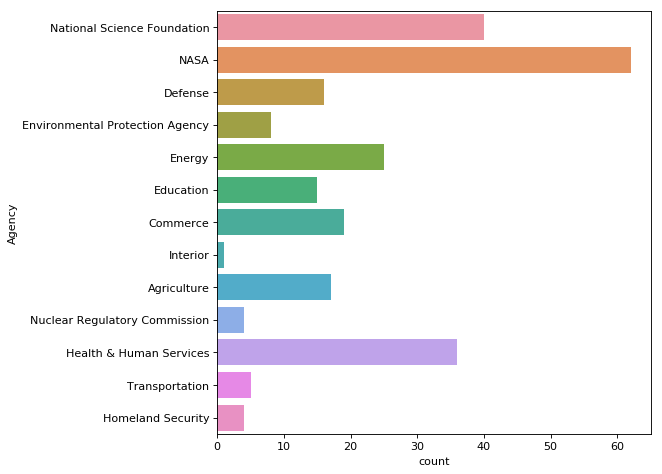

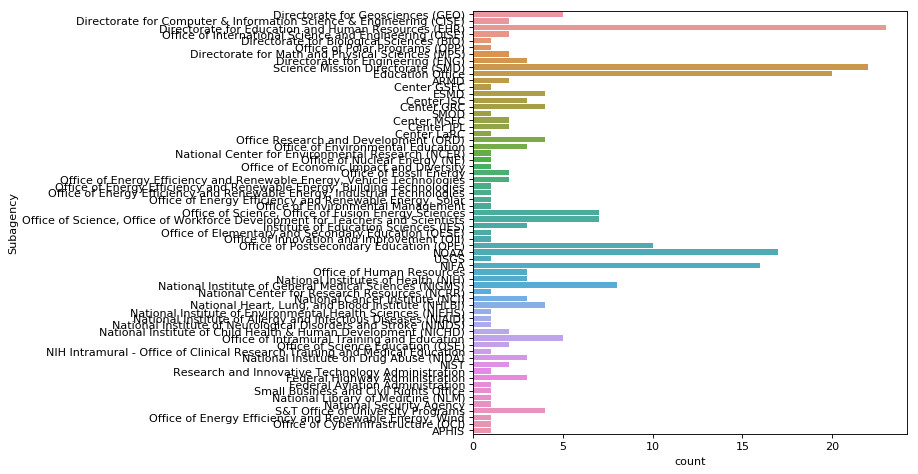

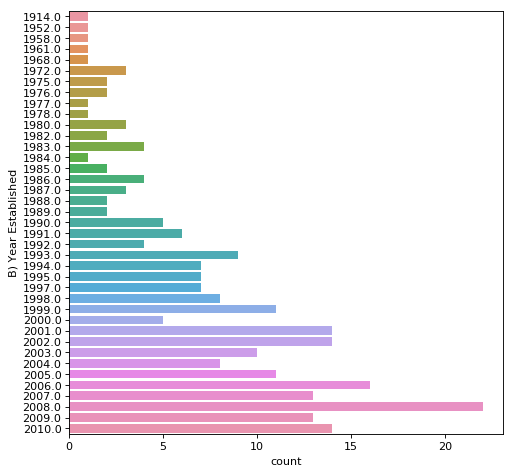

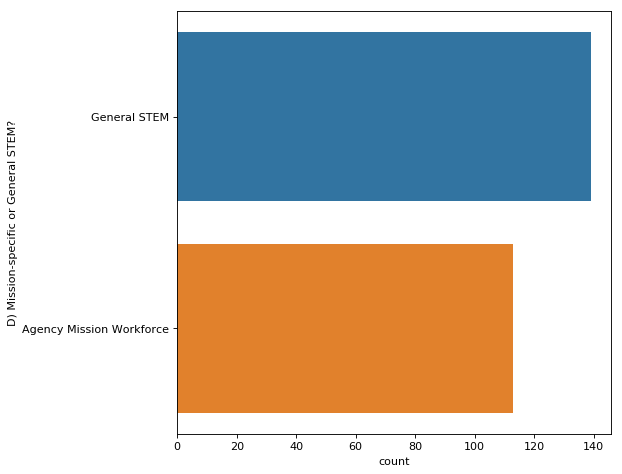

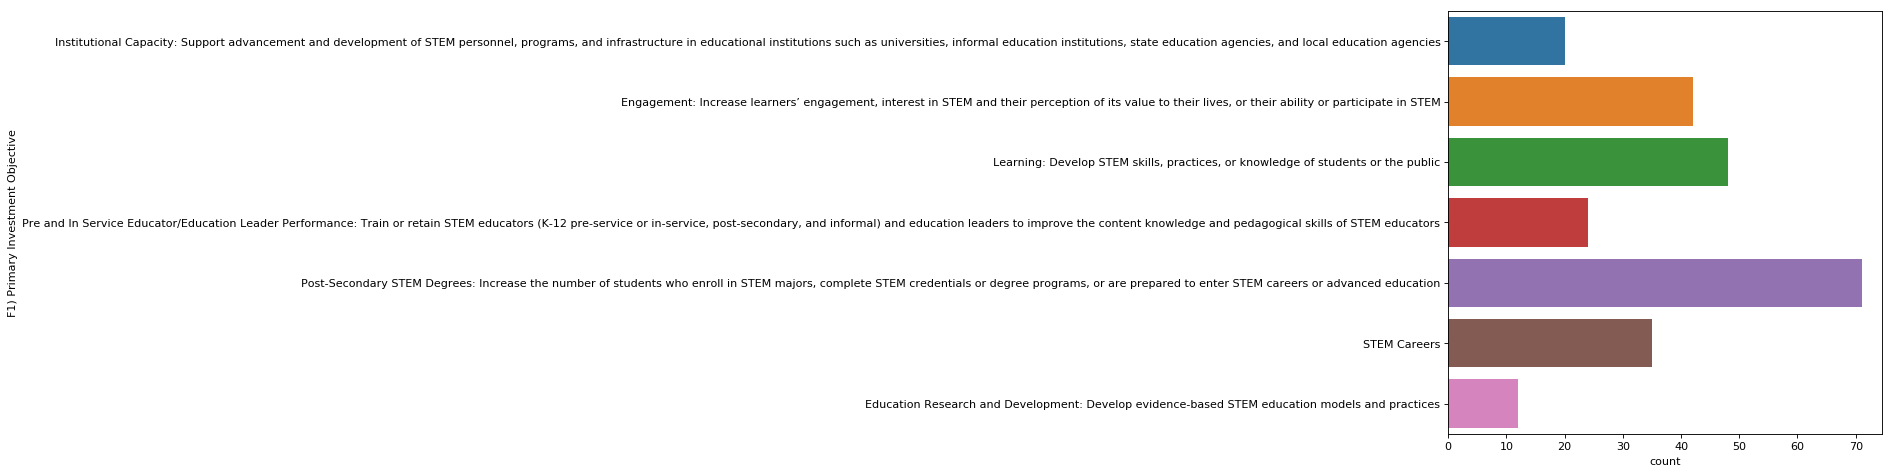

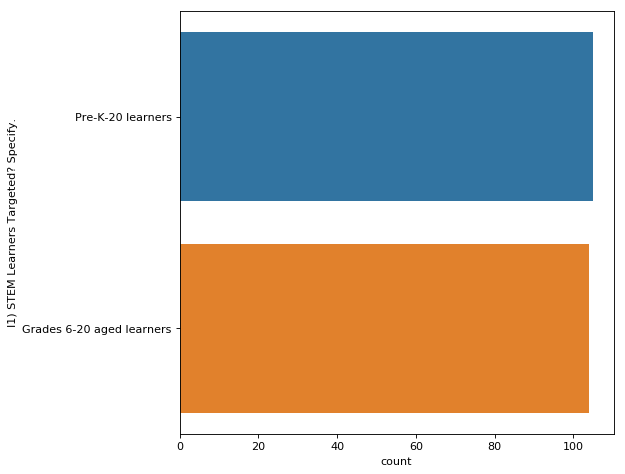

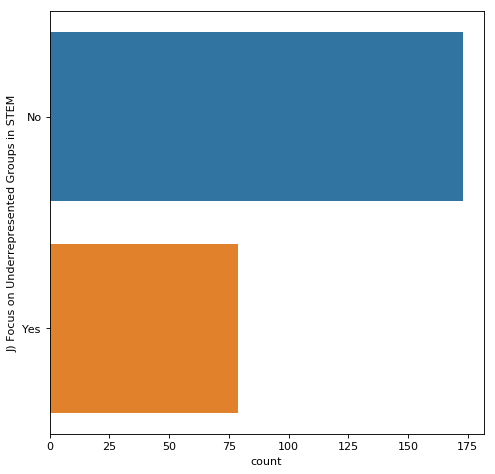

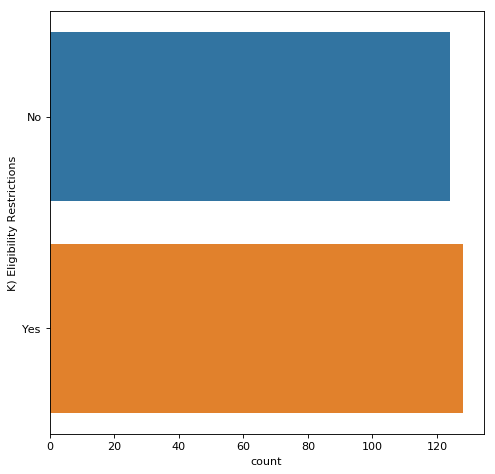

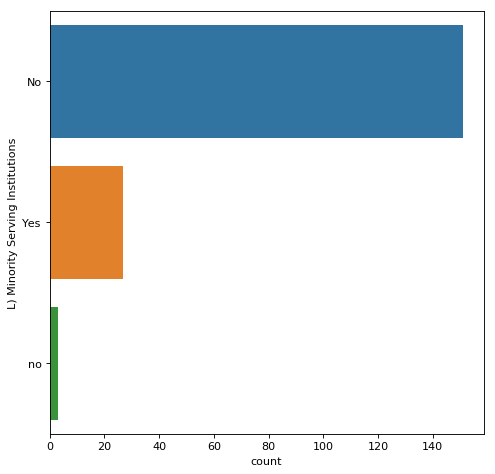

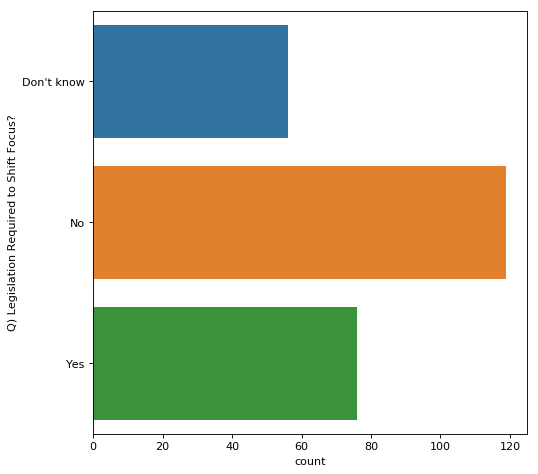

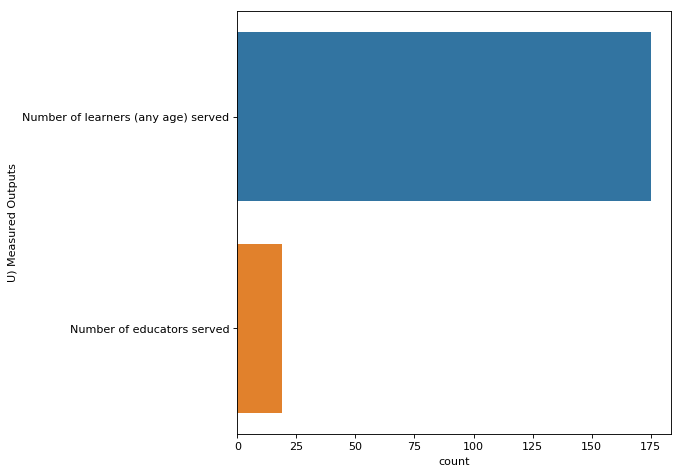

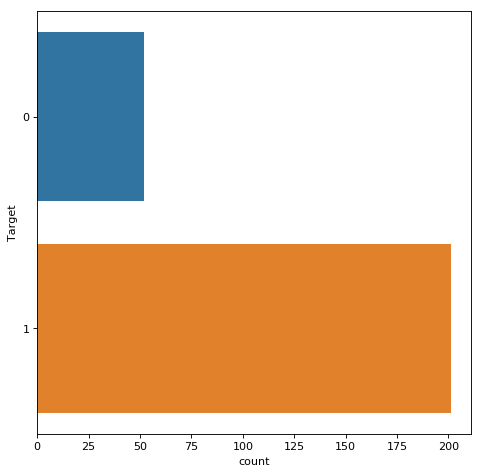

In [17]:
plot(df)

### Compute mutual info score

1. Compute mutual info score of every variable except the funding variables, with respect to the target variable.
2. Save mutual info score in a csv file 

In [18]:
def compute_mutual_info(df):
    
    y = df['Target']
    
    funding_vars = ['C1) Funding FY2008',
       'C2) Funding FY2009', 'C3) Funding FY2010']

    for i in df.columns[:-1]:
        if i not in funding_vars:
            j=df[i]
            j.replace(df[df[i]!=0][i].unique(),range(1,len(df[df[i]!=0][i].unique())+1),inplace=True)
            
    lt=[]
    for i in df.columns[:-1]:
        if i not in funding_vars:
            j=df[i]
            lt.append(mutual_info_score(j.values,y))
    
    mi_score=pd.DataFrame(lt,columns=["MI_score"])
    mi_score["column_name"]=[col for col in df.columns[:-1] if col not in funding_vars]
    mi_score.set_index("column_name",inplace=True)
    return mi_score    

In [19]:
data=data_retriever(DATA_PATH)

data['Target'] = df.Target

data.fillna(0,inplace=True) 


In [20]:
mutual_info_score = compute_mutual_info(data)
mutual_info_score.to_csv('Mutual_info_score.csv')

In [21]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes

In [22]:
df.head()

,Agency,Subagency,B) Year Established,C1) Funding FY2008,C2) Funding FY2009,C3) Funding FY2010,D) Mission-specific or General STEM?,F1) Primary Investment Objective,I1) STEM Learners Targeted? Specify.,J) Focus on Underrepresented Groups in STEM,K) Eligibility Restrictions,L) Minority Serving Institutions,Q) Legislation Required to Shift Focus?,U) Measured Outputs,Target
0,10,12,2002.0,5.24,7.19,5.70,1,2,-1,0,0,0,0,-1,1
1,10,9,2006.0,14.00,14.00,14.00,1,1,1,1,0,0,0,-1,1
2,10,9,2007.0,5.00,5.00,4.37,1,2,-1,0,0,0,0,-1,1
3,10,12,2002.0,4.57,11.79,4.18,1,1,1,1,0,0,0,1,1
4,10,12,1999.0,1.63,2.74,2.02,1,3,1,0,0,0,0,-1,1


In [23]:
# Create a new feature denoting the time before funding
df['TimeBeforeFunding'] = 2008 - df['B) Year Established']

In [24]:
df['B) Year Established'].fillna(-1,inplace=True)
df['TimeBeforeFunding'].fillna(-1,inplace=True)

In [25]:
Y = df['Target']
df.drop('Target',axis=1,inplace=True)

In [26]:
X = df

In [27]:
smotet = SMOTETomek(random_state=42,m=10)
X, Y = smotet.fit_sample(X, Y)
X= pd.DataFrame(X)
y=pd.DataFrame(Y)

/home/mukesh/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/mukesh/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


### Stage. 3

1. Divide the data into train and test samples (70% train, 30% test).
2. Train a XGBoost classifier
3. Compute roc_auc score
4. Plot ROC curve

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier().fit(X_train,Y_train)

from sklearn.metrics import roc_auc_score

preds = xgb.predict(X_test)

/home/mukesh/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
roc_auc_score(Y_test,preds)

0.9063413208649912

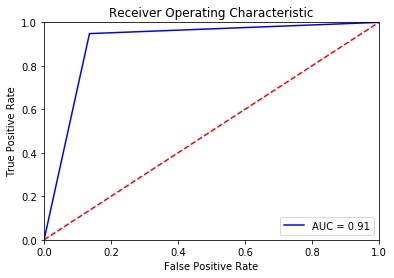

In [31]:
fpr, tpr, thresholds = roc_curve(Y_test, preds, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Testing with pytest

In [32]:
__file__ = 'Federal education inventory data analysis.ipynb'

import ipytest.magics
import pytest

In [33]:
%%run_pytest[clean] 

def test_data_retriever():
    assert len(data_retriever(DATA_PATH).columns.tolist()) == 256
    assert isinstance(data_retriever(DATA_PATH),pd.DataFrame)  

============================= test session starts ==============================
platform linux -- Python 3.6.5, pytest-3.7.0, py-1.5.4, pluggy-0.7.1
rootdir: /home/mukesh/Documents/Machine_learning/Red_carpet_UP, inifile:
collected 1 item

Federal education inventory data analysis.py .                           [100%]

=========================== 1 passed in 0.79 seconds ===========================


In [34]:
%%run_pytest[clean]

#Checks whether compute_growth(), computes the growth for every data_point in 2008 & 2009
def test_compute_growth():
    data = data_retriever(DATA_PATH)
    assert len(compute_growth(data)) == 253

============================= test session starts ==============================
platform linux -- Python 3.6.5, pytest-3.7.0, py-1.5.4, pluggy-0.7.1
rootdir: /home/mukesh/Documents/Machine_learning/Red_carpet_UP, inifile:
collected 1 item

Federal education inventory data analysis.py .                           [100%]

=========================== 1 passed in 0.41 seconds ===========================
